#Mount and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Feb  6 05:01:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!pip install openpyxl==3.0.0
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/iR00i/JUST-Arabic-Propaganda.git

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 30.5 MB/s 
     |████████████████████████████████| 2.9 MB 28.7 MB/s 
     |████████████████████████████████| 126 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 172 kB 4.2 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=464bbf8959d3b8f6af31c30487a789fa1620573a7b5086c6c43b2ee481dee836
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9
Cloning into 'arabert'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 559 (delta 184), reused

In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from arabert.preprocess import ArabertPreprocessor
import transformers
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix
%matplotlib inline

#Utility

##Preprocessing

In [7]:
def MapLabels(df):
  """
  Function to preprocess data.
  Creates a one-hot-encoded version of the labels.
  """
  onehot_col = []
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
  }

  for idx,row in df.iterrows():
    temp = [0] * 14
    label = row['label']
    temp[map[label]] = 1
    onehot_col.append(temp)
  
  df['onehot'] = onehot_col
  return df

In [8]:
def translate_predictions(preds):
  """
  Function to map from a one-hot encoded vector to the actual predicted label.
  This function is used after the ensemble model outputs its predictions for 
  the test dataset.
  
  @args:
  preds: a list of one-hot encoded vectors (2D array). The length of each 
  one-hot encoded vector is equal to the number of labels. The length of "preds"
  is equal to the length of the test dataset.
  """
  map = {
      'Appeal_to_Authority':0,
      'Appeal_to_fear-prejudice':1,
      'Bandwagon,Reductio_ad_hitlerum':2,
      'Black-and-White_Fallacy':3,
      'Causal_Oversimplification':4,
      'Doubt':5,
      'Exaggeration,Minimisation':6,
      'Flag-Waving':7,
      'Loaded_Language':8,
      'Name_Calling,Labeling':9,
      'Repetition':10,
      'Slogans':11,
      'Thought-terminating_Cliches':12,
      'Whataboutism,Straw_Men,Red_Herring':13
      }
  key_list = list(map.keys())
  val_list = list(map.values())
  translation = []
  for i in range(len(preds)):
    temp = []
    for j in range(len(preds[i])):
      if preds[i][j]:
        temp.append(key_list[j])
    translation.append(temp)
  return translation

##Dataset Class

In [9]:
class Dataset:
  """
  Class Dataset used to create an iterable version of the dataset with the
  ability to return the text tokenized upon indexing.

  An object of this class can be treated as a list object. Indexing with this 
  object (ex: dataset[idx] ) will return a dictionary. 
  """
  def __init__(self, text, target):
    self.text = text
    self.target = target
    self.max_len = config['MAX_LEN']

  def __len__(self):
    return len(self.text)
  
  def getitem(self, item, tokenizer):
    text = str(self.text[item])
    text = " ".join(text.split())

    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation='longest_first'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(self.target[item], dtype=torch.float),
    }

##Ensemble Prediction

In [10]:
def predict(model, ids, token_type_ids, mask):
  outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
  prediction = F.softmax(outputs, dim = 1).cpu().detach().numpy()
  prediction = np.squeeze(prediction, axis = 0)
  prediction = (prediction >=0.5).astype(int).tolist()
  return prediction

In [11]:
def Ensemble(models, test, weights=None, no_labels = False):
  if weights is None:
    weights = [1]*len(models)
  if no_labels:
    onehot = [[0]*14] * len(test)
    test['onehot'] = onehot
  else:
    test = MapLabels(test)
  test_dataset = Dataset(
        text=test['Arabic'].values,
        target=test['onehot'].values,
    )
  predictions = []
  targets = test['onehot'].values.tolist()
  print("Using models:\n")
  for model in models:
    print(model.model_id)
  for i in tqdm(range(len(test))):

    ensemble_predictions = []
    for model in models:
      data = test_dataset.getitem(i, model.tokenizer)
      ids = data['ids'].unsqueeze(dim=0).to(device)
      token_type_ids = data['token_type_ids'].unsqueeze(dim=0).to(device)
      mask = data['mask'].unsqueeze(dim=0).to(device)
      prediction = predict(model,
                          ids=ids,
                          token_type_ids=token_type_ids,
                          mask=mask)
      ensemble_predictions.append(prediction)
    avg = np.average(np.array(ensemble_predictions), axis=0, weights=weights)
    avg = (avg >=0.5).astype(int).tolist()
    predictions.append(avg)

  f1_micro = metrics.f1_score(targets, predictions,average='micro')
  accuracy = metrics.accuracy_score(targets, predictions)
  print(f"<---------------Test Set Performance--------------->")
  print(f"f1-Micro Score = {f1_micro}")
  print(f"Accuracy Score = {accuracy}")

  return predictions, targets

In [12]:
def load_transformer(model_args):
  tokenizer = transformers.BertTokenizer.from_pretrained(model_args['model_id'])
  model = TransformerModel(model_id = model_args['model_id'],
                            hidden_size = model_args['hidden_size'],
                            num_labels = model_args['num_labels'],
                            tokenizer=tokenizer,
                            )

  model.load_state_dict(torch.load(model_args['model_path']))

  model.eval()
  model.to(device)

  return model

##Evaluation code

In [13]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

#Architectures

In [14]:
class TransformerModel(nn.Module):
  def __init__(self, model_id, hidden_size, num_labels, tokenizer):
    super(TransformerModel, self).__init__()
    self.model_id = model_id
    self.tokenizer = tokenizer

    self.bert = transformers.BertModel.from_pretrained(model_id, return_dict=False)
    self.bert_drop = nn.Dropout(0.0)
    self.out = nn.Linear(hidden_size, num_labels)


  def forward(self, ids, mask, token_type_ids):
    _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
    bo = self.bert_drop(o2)
    output = self.out(bo)
    return output


#config

In [15]:
"""
aubmindlab/bert-base-arabertv02
asafaya/bert-base-arabic
kuisailab/albert-base-arabic
UBC-NLP/ARBERT
UBC-NLP/MARBERT
"""
config = {
    'MAX_LEN':200,
    'DEVICE':'cuda',
    'results_save_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/",
}
device = torch.device(config['DEVICE'])

In [16]:
path = r'/content/JUST-Arabic-Propaganda/data/Translated Data/'
# train = pd.read_csv(path+'train.csv')
# valid = pd.read_csv(path+'valid.csv')
test = pd.read_csv(path+'test.csv')

#Load models

TODO: add "load transformer" function.

In [17]:
model_args = {
    'model_id':'asafaya/bert-base-arabic',
    'hidden_size':768,
    'num_labels':14,

    'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/Asafya.bin",
}

model_1 = load_transformer(model_args=model_args)

Downloading:   0%|          | 0.00/334k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [18]:
model_args = {
    'model_id':'UBC-NLP/ARBERT',
    'hidden_size':768,
    'num_labels':14,

    'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/ARBERT.bin",
}

model_2 = load_transformer(model_args=model_args)

Downloading:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/374 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [19]:
model_args = {
    'model_id':'aubmindlab/bert-base-arabertv02',
    'hidden_size':768,
    'num_labels':14,

    'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/Arabert.bin",
}

model_3 = load_transformer(model_args=model_args)

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [20]:
# model_args = {
#     'model_id':'UBC-NLP/MARBERT',
#     'hidden_size':768,
#     'num_labels':14,

#     'model_path':"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Ensembles/model.bin",
# }

# model_4 = load_transformer(model_args=model_args)

#Run

In [21]:
models = [model_1, model_2, model_3]
predictions, targets = Ensemble(models, test)

Using models:

asafaya/bert-base-arabic
UBC-NLP/ARBERT
aubmindlab/bert-base-arabertv02


  0%|          | 0/720 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Micro Score = 0.6607929515418502
Accuracy Score = 0.625


Using models:

asafaya/bert-base-arabic
UBC-NLP/ARBERT
aubmindlab/bert-base-arabertv02

Accuracy= 0.625
                                    precision    recall  f1-score   support

               Appeal_to_Authority     0.5333    0.5000    0.5161        16
          Appeal_to_fear-prejudice     0.4062    0.3824    0.3939        34
    Bandwagon,Reductio_ad_hitlerum     0.5000    0.1429    0.2222         7
           Black-and-White_Fallacy     0.5000    0.1538    0.2353        13
         Causal_Oversimplification     0.5500    0.4783    0.5116        23
                             Doubt     0.6604    0.6250    0.6422        56
         Exaggeration,Minimisation     0.5333    0.4444    0.4848        54
                       Flag-Waving     0.8500    0.5312    0.6538        32
                   Loaded_Language     0.7934    0.7837    0.7885       245
             Name_Calling,Labeling     0.7154    0.7097    0.7126       124
                        Repetition     0.7460    0.6104    

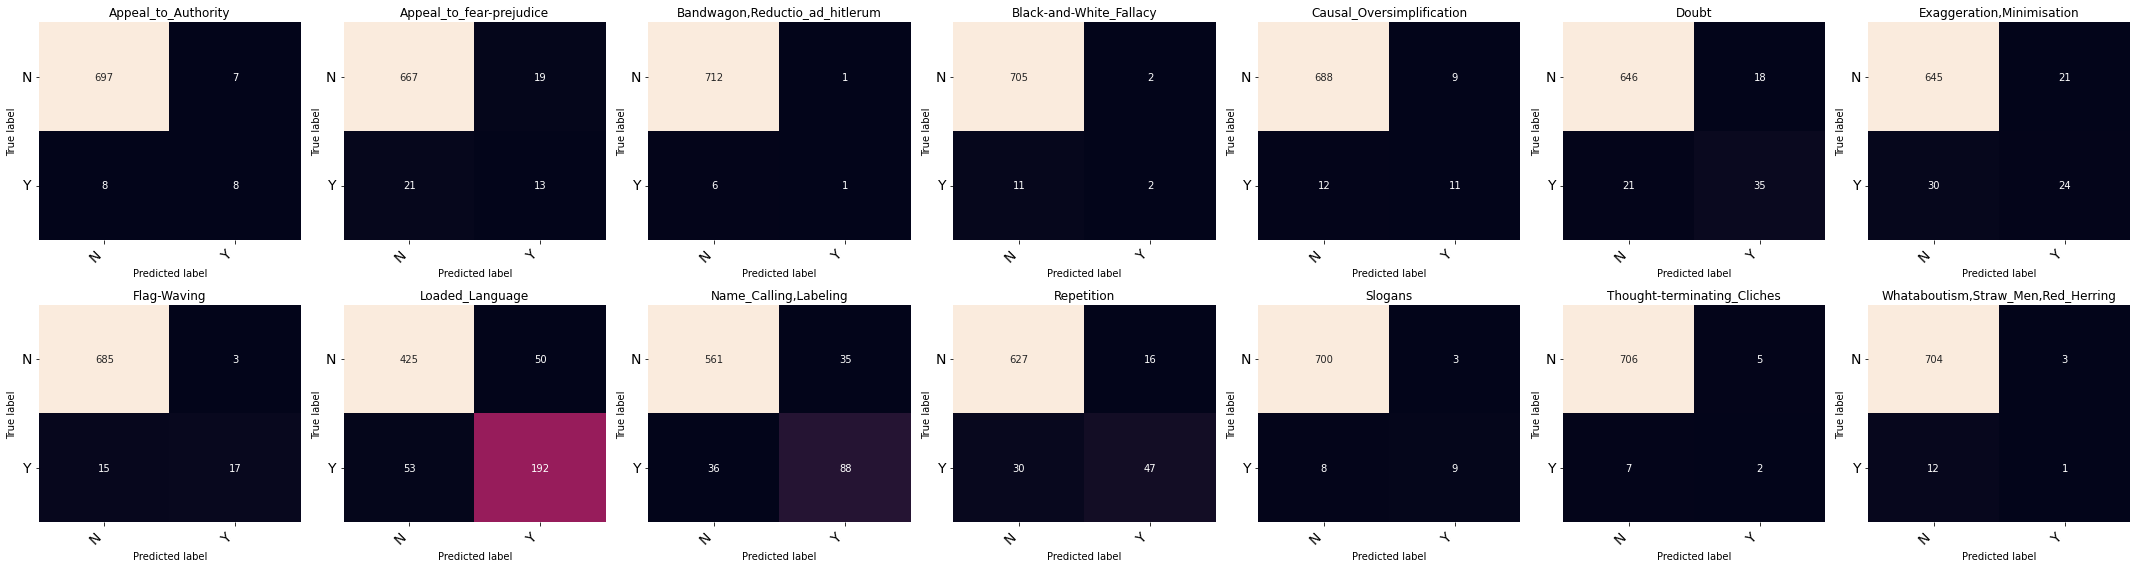

In [22]:
#@title Get Confusion Matrix for each Label
gold_list = targets
preds_list = predictions

target_names = [
      'Appeal_to_Authority',
      'Appeal_to_fear-prejudice',
      'Bandwagon,Reductio_ad_hitlerum',
      'Black-and-White_Fallacy',
      'Causal_Oversimplification',
      'Doubt',
      'Exaggeration,Minimisation',
      'Flag-Waving',
      'Loaded_Language',
      'Name_Calling,Labeling',
      'Repetition',
      'Slogans',
      'Thought-terminating_Cliches',
      'Whataboutism,Straw_Men,Red_Herring']

print("Using models:\n")
for model in models:
  print(model.model_id)
report = metrics.classification_report(gold_list, preds_list, target_names=target_names,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)

print()
print(f"Accuracy= {accuracy}")
print(report)

fig, ax = plt.subplots(2, 7, figsize=(30, 8))
for axes, cmi, label in zip(ax.flatten(), cm, target_names):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()

plt.show()
fig.savefig(config['results_save_path']+"confusion_matrices.png")

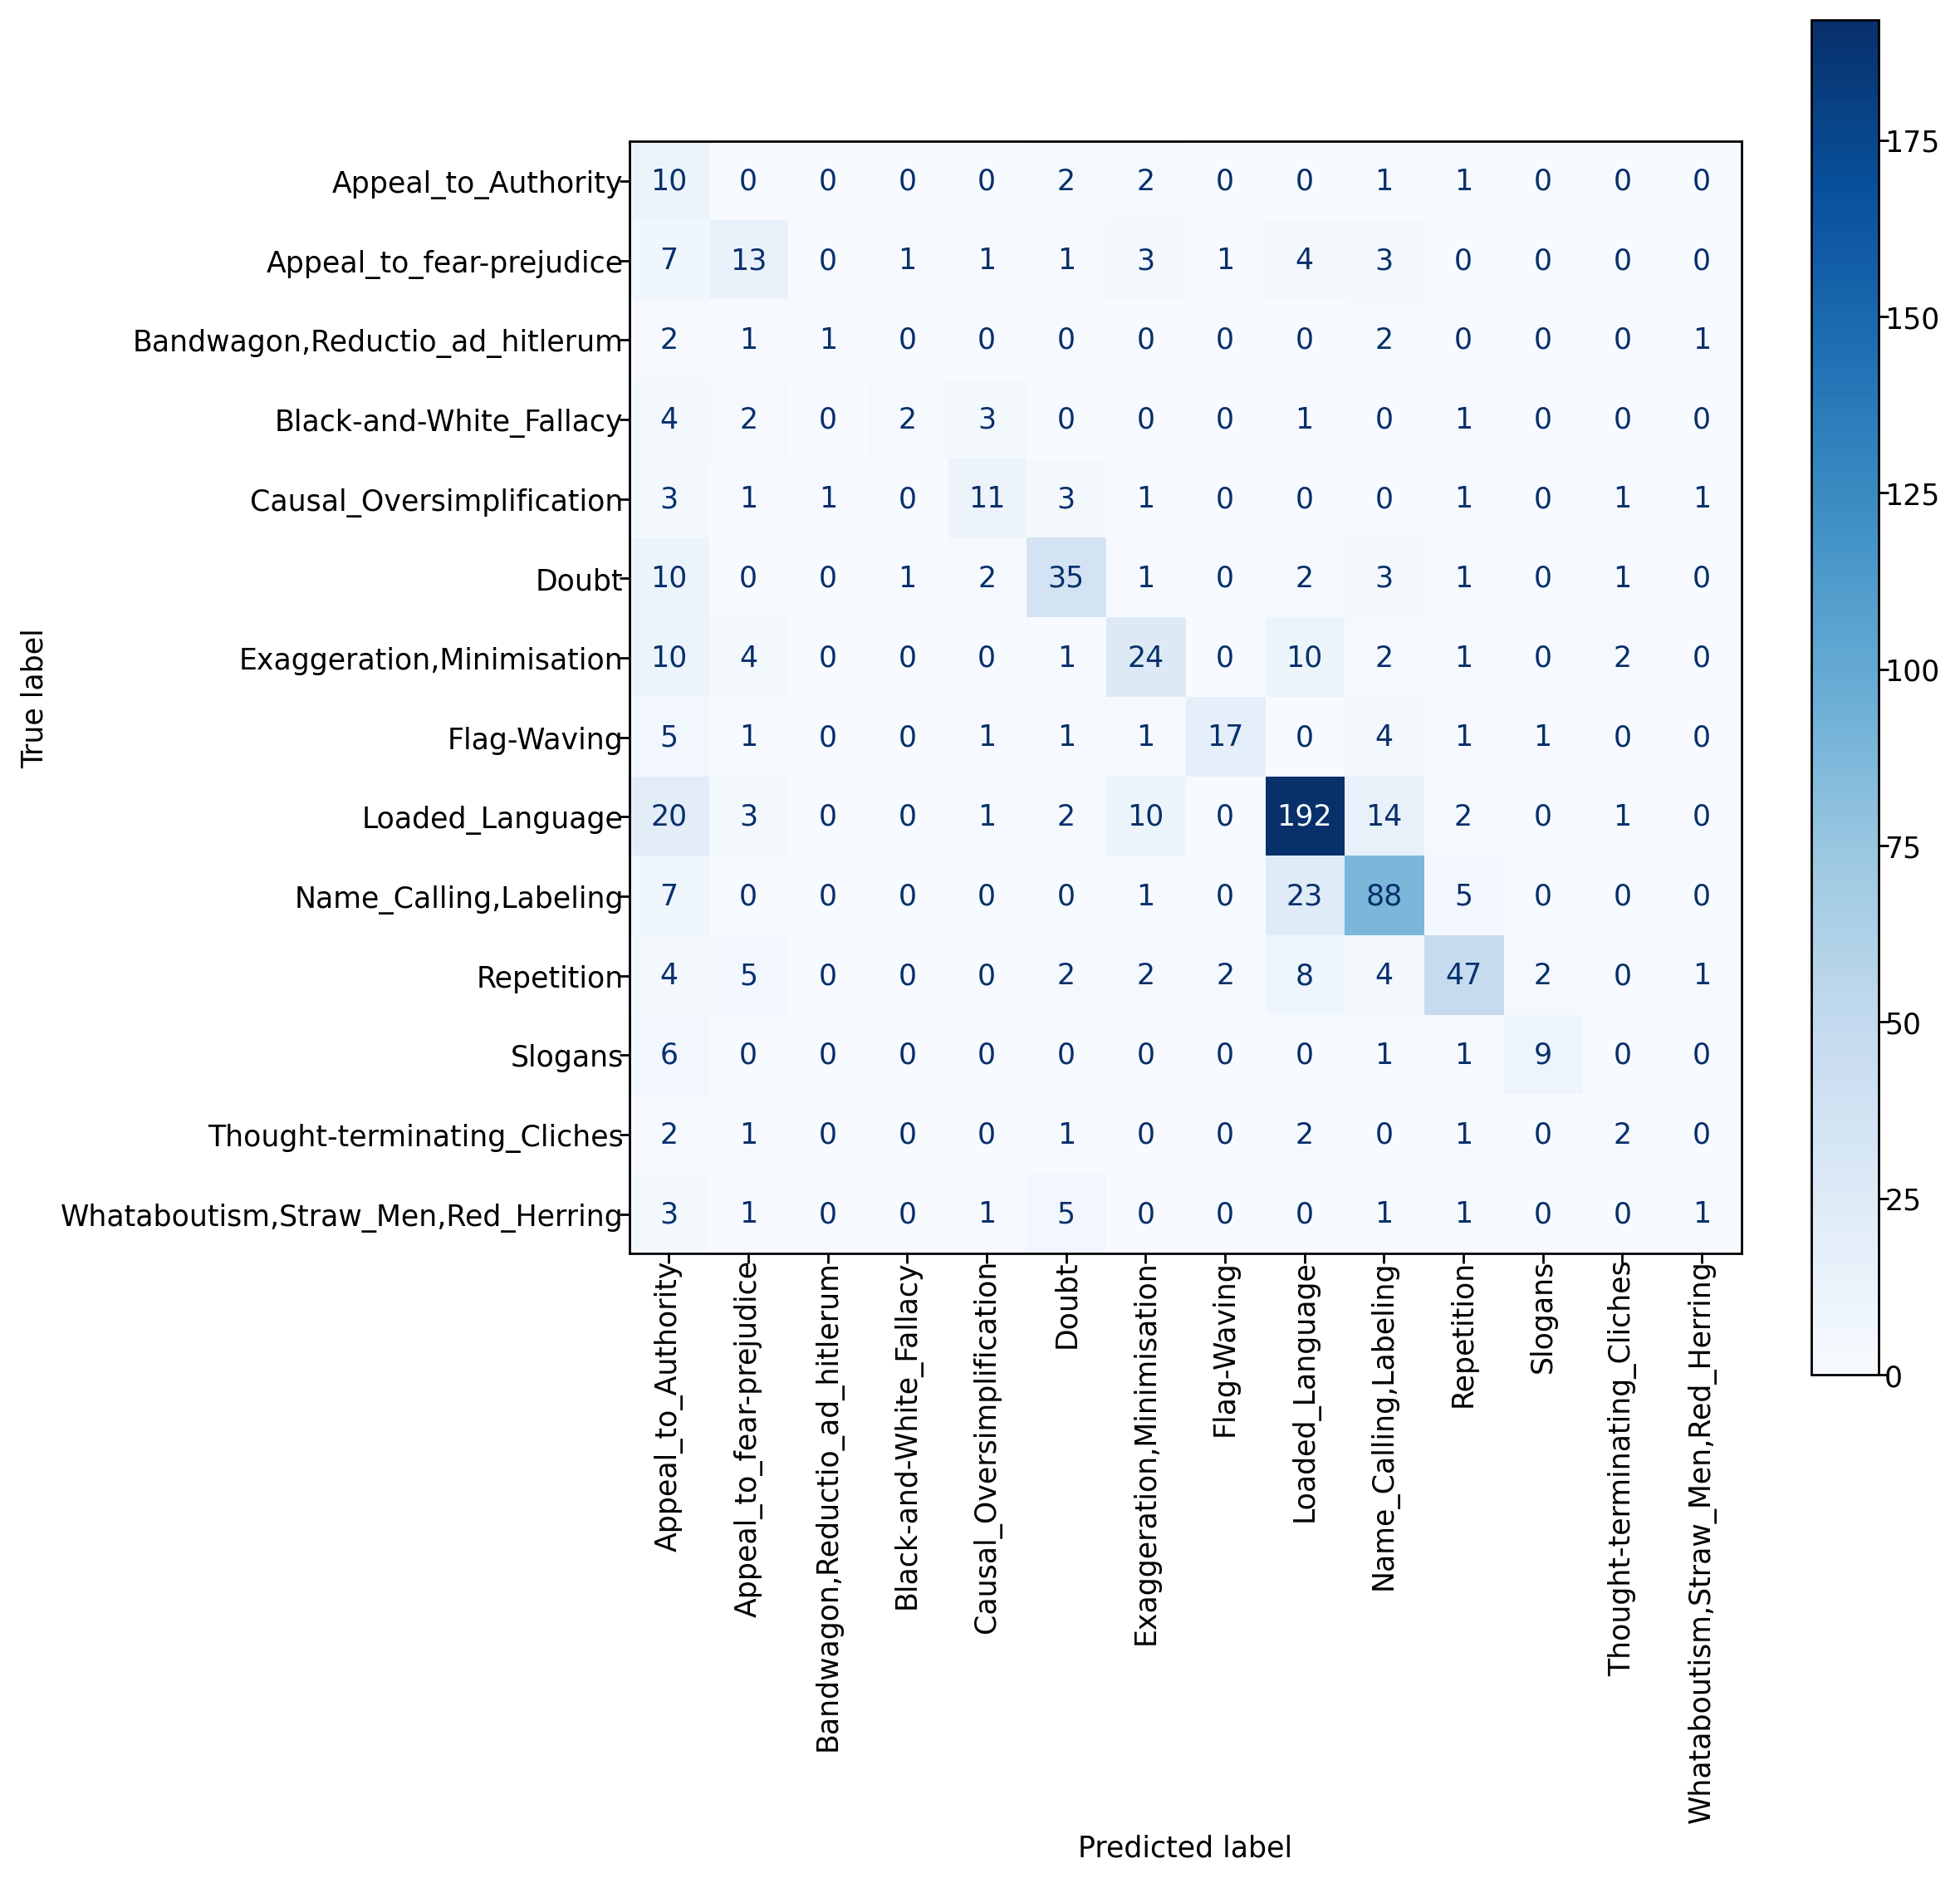

In [23]:
#@title Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

try:
  preds_list = [[int(i) for i in row] for row in preds_list]
  preds_list = [i.index(max(i)) for i in preds_list]
  gold_list = [i.index(max(i)) for i in gold_list]
except:
  print("Make sure preds_list and gold_list are lists of one-hot encoded vectors!")

cm = confusion_matrix(gold_list, preds_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = target_names)
fig, ax = plt.subplots(figsize = (30,30))
disp.plot(ax=ax,cmap="Blues")
plt.Figure.dpi = 250
plt.xticks(rotation=90)
plt.show()

#Arabic News Tweets

In [ ]:
models = [model_1, model_2, model_3]
ACPC = pd.read_excel("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_COVID/Twitter Data/Stage_2/ACPC.xlsx")
predictions, targets = Ensemble(models, ACPC)

Using models:

asafaya/bert-base-arabic
UBC-NLP/ARBERT
aubmindlab/bert-base-arabertv02


  0%|          | 0/300 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Micro Score = 0.31163708086785
Accuracy Score = 0.2633333333333333
